In [1]:
import numpy as np
import os
import glob
from collections import OrderedDict
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
import stistools
from astropy import table

#For running specutils
import specutils
from specutils.analysis import Splice
from astropy import units as u
from astropy.nddata import StdDevUncertainty

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'inferno'

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


In [2]:
# If $oref is not defined on your system, you may use the CRDS location:
os.environ['oref'] = '/grp/hst/cdbs/oref/' 
# Trailing '/' is required!

<br>
<br>
------------------------------------------------------------------------

## IRAF `splice` Documentation

```
SPLICE (Jul2000)                 ctools                 SPLICE (Jul2000)



NAME
    splice -- Splice spectra that were written by 'x1d'.
    
    
USAGE
    splice intable outable
    
    
DESCRIPTION
    This task is used to splice spectra, averaging in overlap regions.
    All rows of all input tables will be combined, producing one output
    spectrum.
    
    The wavelengths for the output spectrum can be specified explicitly
    by setting 'wavetab' to the name of a table of wavelengths.  If a
    table of wavelengths is not specified, the output wavelengths will
    be computed by 'splice' such that the wavelengths will vary
    smoothly.  Note that the wavelengths will typically not be
    uniformly spaced.  Wavelengths in all tables are assumed to be
    strictly increasing.  See the 'wavetab' and 'spacing' parameters
    for further information.
    
    The computations to determine the output FLUX, ERROR, and DQ values
    are accomplished as follows:
    
        tot_wgt(k)   = sum (wgt(i,j) * sw * dlambda)
    
        out_flux(k)  = sum (in_flux(i,j) * wgt(i,j) * sw * dlambda) / tot_wgt(k)
    
        out_error(k) = sqrt[ sum ((in_error(i,j) * wgt(i,j) * dlambda)**2) ] /
                             tot_wgt(k)
    
        out_dq(k)    = in_dq(i,j) OR out_dq(k)
    
        where
            i   = index over input arrays
            j   = index over wavelength bins in each input array
            k   = index over wavelength bins in the output array
            dlambda = overlap region of current input bin to current output
                      bin in Angstroms
            sw  = input scalar weight
            wgt(i,j)      = input weight in wavelength bin j for spectrum i
            in_flux(i,j)  = input flux in wavelength bin j for spectrum i
            in_error(i,j) = input error in wavelength bin j for spectrum i
            in_dq(i,j)    = input dq in wavelength bin j for spectrum i
    
            out_flux(k)  = output flux for bin k
            out_error(k) = output error for bin k
            out_dq(k)    = output dq for bin k
    
    
    The input data bins are assigned to the output data bins according
    to the overlap of the input and output wavelengths.  If the DQ
    value for an input bin is found to satisfy the 'sdqflags' parameter
    (i.e, the DQ value is a component of the 'sdqflags' value), then
    the data from that input bin will NOT be used in the combination
    process.  The wavelengths in the input and output tables are given
    at pixel centers, and the wavelengths are typically not uniformly
    spaced.  'splice' must therefore compute wavelengths at the pixel
    edges in order to determine the limits of each bin, then accumulate
    flux into bins, then convert the output wavelengths back to
    wavelengths at the pixel centers.  The method used for computing
    wavelengths at pixel edges is as follows.  If wl[i] and wl[i+1] are
    wavelengths at pixel centers, the pixel edge between them is taken
    to be (wl[i] + wl[i+1]) / 2.  The left edge of the first pixel is
    wl[1] - (wl[2] - wl[1]) / 2, with a similar expression for the
    right edge of the last pixel.
    
    If the first input table and the output table are both FITS files,
    and if the output file does not already exist, the primary header
    of the first input table will be copied to output, and HISTORY
    records will be added giving the names of the input tables.
    
    The columns in the output table will contain either scalar values
    or arrays, depending on the WAVELENGTH column in the first input
    table.  While the test is made on the WAVELENGTH column alone, it
    is assumed that the WAVELENGTH, FLUX, ERROR, DQ, and WEIGHT columns
    will all have the same length (one if scalar, or typically 1024 if
    array).  However, some tables in the input list may contain scalar
    columns while other tables contain array columns, and the array
    lengths in different tables need not be the same.  The output table
    contains columns for NELEM, WAVELENGTH, FLUX, ERROR, and DQ.
    
    
PARAMETERS
    
    intable [file name template]
        A list of tables to be spliced together.
        
        If an input FITS file contains more than one table that are to
        be combined, each such table needs to be listed individually;
        see example 3.
    
    outtable [file name]
        The name of the output table.
    
    (wavetab = "") [file name]
        The name of an optional table containing a column of
        wavelengths.  If this is null or blank, 'splice' will compute
        the wavelengths.  If 'wavetab' is specified, the wavelengths in
        this table will be used for the output table.  If 'wavetab'
        contains only one column, the column name does not matter.  If
        it contains more than one column, the column name must be given
        by 'wl_name', i.e. the same as the columns in the input tables.
        If the column contains arrays, the table should contain only
        one row; a particular row can be specified using the
        row-selector syntax, e.g. "rootname_x1d.fits[r:sporder=316]".
        The entire allocated array length will be used (i.e. no NELEM
        column is read).  If the wavelength array contains any zero or
        INDEF values, however, the array will be truncated at that
        point.  The wavelengths must be in increasing order.  There
        must be at least two wavelengths in the table; this is because
        'splice' integrates flux into bins, and with only one output
        wavelength, the bin size would be undetermined.
        
        The 'synphot.genwave' task can be used to create a table of
        uniformly spaced wavelengths, based on minimum and maximum
        values and an increment.
    
    (spacing = "coarse") [string, allowed values:  fine | coarse]
        When computing the wavelengths for the output spectrum, this
        parameter specifies whether the wavelengths should be finely
        spaced or coarsely spaced.  This parameter is ignored if
        'wavetab' is specified.  If spacing = "fine", the wavelength
        increment per output pixel will be at least as fine as the
        spacing of any input table at the same wavelength.  If spacing
        = "coarse", the output wavelength increment will be at least as
        large as the spacing of any input table at the same wavelength.
        Resolution is better preserved using fine spacing, but the
        values and errors of nearby pixels will be correlated.  Coarse
        spacing reduces the correlation between adjacent pixels.
    
    (sdqflags = 31743) [integer, min=0, max=32767]
        "Serious" data quality flags, the logical OR of the bit flags
        that are serious enough to warrent excluding the data.  The
        default is (32767 - 1024), which means that all data quality
        flags except "small blemish" (1024) are considered serious.
        "Hot pixel" (16) is another flag that you might want to exclude
        for CCD data, since there can be many pixels flagged as such
        that are really just "warm" rather that "hot" and were
        adequately corrected by the DARKCORR step.
    
    (wl_name = "wavelength") [string]
        The name of column containing the wavelengths.  The name must
        be the same in all input tables.
    
    (flux_name = "flux") [string]
        The name of column containing flux data.
    
    (err_name = "error") [string]
        The name of column containing the statistical error estimates.
    
    (dq_name = "dq") [string]
        The name of column containing data quality values.
    
    (wgt_name = "weight") [string]
        The name of column containing the array of weights.  If a
        column by this name is not found, the weights will be set to
        one.  Values for this column can be generated by 'fweight' or
        'pweight'.
        
        See also the 'sw_name' parameter.
    
    (sw_name = "sweight") [string]
        The name of column containing the scalar weight.  This could be
        the exposure time, for example.  If a column by this name is
        not found, and if the name is not null, 'splice' will look for
        a header keyword.  If neither is found, the scalar weight will
        be set to one.
        
        If 'fweight' or 'pweight' is used to generate the weight column,
        then no scalar weighting should need to be applied, since the
        exposure time will be included in the weight.
        
        If an input table contains scalar columns, the scalar weight
        will be gotten only when reading the first row.
        
        See also the 'wgt_name' parameter.
    
    (n_name = "nelem") [string]
        The name of column containing the number of elements in the
        arrays.  This column is not needed if the input tables contain
        scalar columns rather than arrays.
    
    (verbose = yes) [boolean]
    
    
EXAMPLES
    1.  Splice all rows of o52z24010_x1d.fits.
    
        st> splice o52z24010_x1d.fits splice.fits
    
    2.  Splice all rows of all FITS files in the current directory.
    Use the values in "wl.txt" for the wavelengths in the output table.
    The output can be either FITS or STSDAS format.
    
        st> splice *.fits splice.fits wavetab="wl.txt"
        st> splice *.fits splice.tab wavetab="wl.txt"
    
    3.  Table rpt.fits contains three tables; splice them all together.
    
        st> splice rpt.fits[1],rpt.fits[2],rpt.fits[3] splice.fits
    
    4.  The original table has been converted by 'txtable' from columns
    of arrays to scalars, with file names "x1d_r0001.tab",
    "x1d_r0002.tab", "x1d_r0003.tab", etc.  Splice all these together.
    Since the first input table contains scalar columns, the output can
    even be written to a text file (using STDOUT as the table name sets
    the table type to "text").
    
        st> splice x1d_r*.tab splice.fits
        st> splice x1d_r*.tab splice.tab
        st> splice x1d_r*.tab STDOUT > splice.txt
    
    
BUGS
    
    
REFERENCES
    This task was written by Phil Hodge and Michele De La Pena.
    
    
SEE ALSO
    synphot.genwave, fweight, pweight, sflux
```


---------------------------------------------------------------------------

## 1D Extraction

Let's start working with the science files:

In [4]:
fns = glob.glob(os.path.join('/Users/ogaz/specutils/test_data', '*_flt.fits'))
fns = [fn for fn in fns if 
       (fits.getval(fn, ext=0, keyword='TARGNAME') != 'CCDFLAT')]
fns.sort(key=lambda x: (fits.getval(x, ext=0, keyword='CENWAVE'), fits.getval(x, ext=0, keyword='POSTARG2')))

print ('Exposure      Grating   POSTARG2  Target')
for fn in fns:
    with fits.open(fn) as f:
        print ('{}     {:6}    {:3.1f}       {}'.format(
            f[0].header['ROOTNAME'], f[0].header['OPT_ELEM'], f[0].header['POSTARG2'], f[0].header['TARGNAME']))

Exposure      Grating   POSTARG2  Target
ocr7ncmcq     G230LB    0.0       HD115383
ocr7ncmdq     G230LB    0.5       HD115383
ocr7ncmfq     G430L     0.0       HD115383
ocr7ncmeq     G430L     0.5       HD115383
ocr7ncmgq     G750L     0.0       HD115383
ocr7ncmhq     G750L     0.5       HD115383
ocr7ncmiq     G750L     0.5       HD115383


In [9]:
rootname

'ocr7ncmcq'

In [17]:
# Background regions determined from cross-dispersion plots to follow:
bk1offst = -40
bk2offst =  55

# (The default extraction offset would have been outside the subarray and flag every pixel with DQ=2048.)

outnames = OrderedDict()
for fn in fns:
    # Input/output filenames:
    rootname = os.path.basename(fn.rsplit('_',1)[0])
    trl_file = os.path.join('/Users/ogaz/specutils/test_data', rootname + '_trl.txt')
    outname = os.path.join('/Users/ogaz/specutils/test_data', rootname + '_x1d.fits')
    
    print(fn)
    
    # Remove previous versions of the 1D file and log:
    if os.access(outname, os.F_OK):
        os.remove(outname)
    if os.access(trl_file, os.F_OK):
        os.remove(trl_file)
    
    # Call x1d on the 2D FLT file:
    status = stistools.x1d.x1d(fn, output=outname, trailer=trl_file, 
                      backcorr='perform', ctecorr='perform', dispcorr='perform', 
                      helcorr='perform', fluxcorr='perform', 
                      bk1offst=bk1offst, bk2offst=bk2offst, backord=1)
    
    # Check x1d call for errors and print the log:
    assert status == 0, 'Problem running x1d!  {}'.format(status)
    ## To print the contents of the log files here:
    #with open(trl_file) as f:
    #    for line in f:
    #        print (line.rstrip())
    
    outnames[fn] = outname

/Users/ogaz/specutils/test_data/ocr7ncmcq_flt.fits
/Users/ogaz/specutils/test_data/ocr7ncmdq_flt.fits
/Users/ogaz/specutils/test_data/ocr7ncmfq_flt.fits
/Users/ogaz/specutils/test_data/ocr7ncmeq_flt.fits
/Users/ogaz/specutils/test_data/ocr7ncmgq_flt.fits
/Users/ogaz/specutils/test_data/ocr7ncmhq_flt.fits
/Users/ogaz/specutils/test_data/ocr7ncmiq_flt.fits


Sub-array Y-ranges:
ocr7ncmcq_flt.fits	834 -- 962
ocr7ncmdq_flt.fits	844 -- 972
ocr7ncmfq_flt.fits	834 -- 962
ocr7ncmeq_flt.fits	844 -- 972
ocr7ncmgq_flt.fits	451 -- 579
ocr7ncmhq_flt.fits	461 -- 589
ocr7ncmiq_flt.fits	461 -- 589


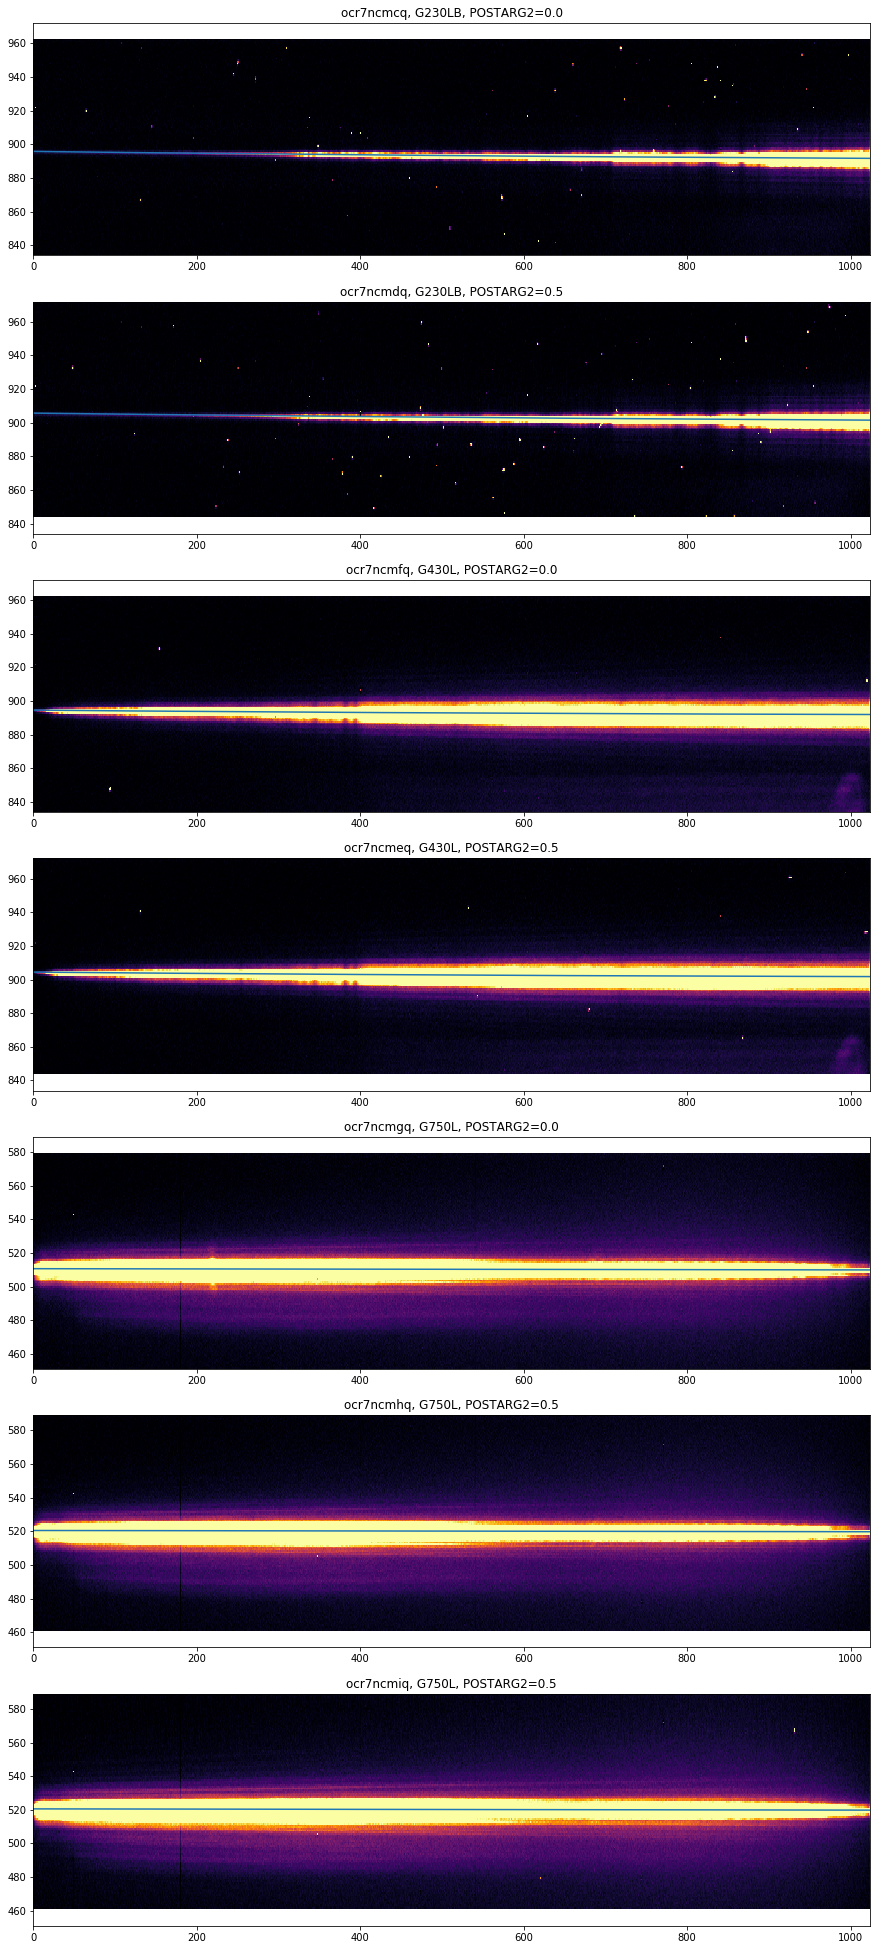

In [18]:
fig, axes = plt.subplots(7, 1, sharey=False)
fig.set_size_inches(15, 7 * 5)

print ('Sub-array Y-ranges:')
for ax, fn in zip(axes, fns):
    with fits.open(fn) as f, fits.open(outnames[fn]) as x1d:
        ax.imshow(f[1].data, vmin=0, vmax=200, aspect='auto', interpolation='none', 
                  extent=[0, 1024, -f[1].header['LTV2'], -f[1].header['LTV2'] + f[1].header['NAXIS2']])
        print ('{}\t{:.0f} -- {:.0f}'.format(os.path.basename(fn), 
                                           -f[1].header['LTV2'], -f[1].header['LTV2'] + f[1].header['NAXIS2']))
        ax.plot(x1d[1].data[0]['EXTRLOCY'] - f[1].header['LTV2'])
        ax.set_title('{}, {}, POSTARG2={}'.format(
            f[0].header['ROOTNAME'], f[0].header['OPT_ELEM'], f[0].header['POSTARG2']))

[ax.set_ylim(834, 972) for ax in axes[0:4]]
[ax.set_ylim(451, 589) for ax in axes[4:7]]
None

## Selecting Custom Background Subtraction Regions

Determine background offsets that work with the smaller subarrays, as used above in `bk1offst` and `bk2offst`:

bk1offst:   -40
bk2offst:   +55


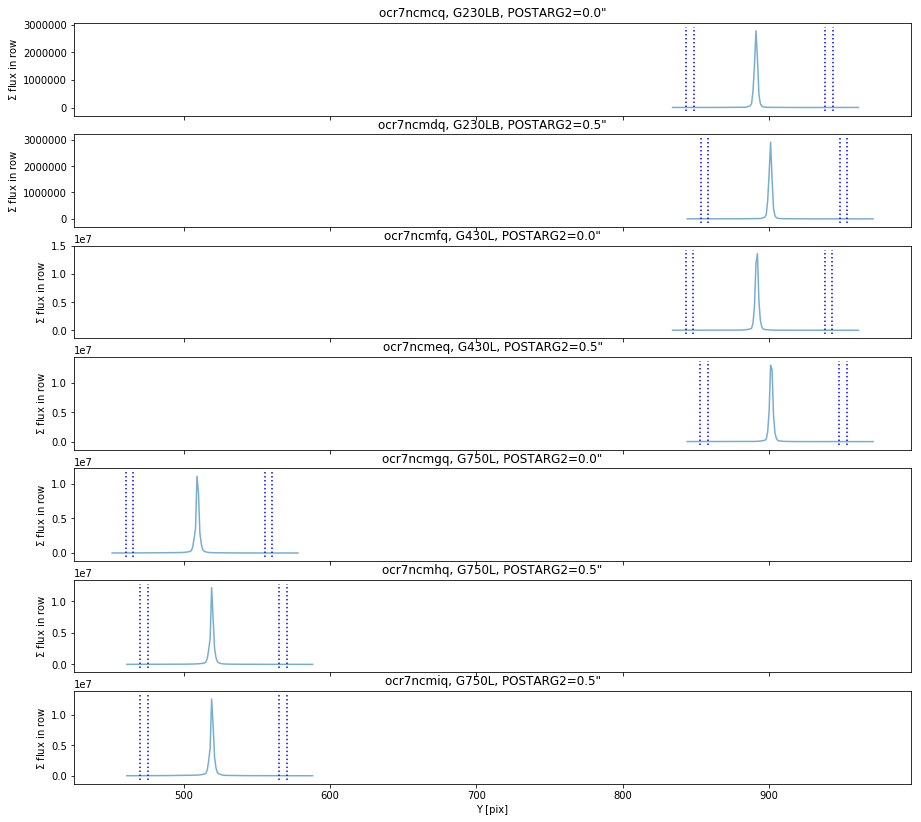

In [19]:
fig, axes = plt.subplots(7, 1, sharex=True)
fig.set_size_inches(15, 14)

for ax, fn in zip(axes, fns):
    with fits.open(fn) as f, fits.open(outnames[fn]) as x1d:
        ax.plot(np.arange(-f[1].header['LTV2'], -f[1].header['LTV2'] + f[1].header['NAXIS2']), 
                np.sum(f[1].data, axis=1), alpha=0.6)
        ylim = ax.get_ylim()
        ax.plot(np.array([-40-2.5,-40-2.5]) + x1d[1].data[0]['OFFSET'], ylim, 'b:')
        ax.plot(np.array([-40+2.5,-40+2.5]) + x1d[1].data[0]['OFFSET'], ylim, 'b:')
        ax.plot(np.array([ 55-2.5, 55-2.5]) + x1d[1].data[0]['OFFSET'], ylim, 'b:')
        ax.plot(np.array([ 55+2.5, 55+2.5]) + x1d[1].data[0]['OFFSET'], ylim, 'b:')
        
        ax.set_ylabel('$\Sigma$ flux in row')
        ax.set_title('{}, {}, POSTARG2={}"'.format(
            f[0].header['ROOTNAME'], f[0].header['OPT_ELEM'], f[0].header['POSTARG2']))

axes[-1].set_xlabel('Y [pix]')

print ('bk1offst:  {:+4.0f}\nbk2offst:  {:+4.0f}'.format(bk1offst, bk2offst))

--------------------------------------------------------------------------------

## Selecting Serious DQ Flags

Data quality (DQ) flags, as defined in the [STIS Data Handbook](http://www.stsci.edu/hst/stis/documents/handbooks/currentDHB/ch2_stis_data6.html#384192):

(Note that the CCD does indeed have DQ=1024 defined.)

<table>
 <tbody><tr>
    <td style="background-color: #E0E0E0; border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 3.0pt; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: middle; width: 40pt">
      <div class="TableColumnHead" style="color: #000000; font-family: Arial; font-size: 9.0pt; font-style: normal; font-variant: normal; font-weight: bold; margin-right: 0.0pt; text-indent: 0pt; text-transform: none; vertical-align: baseline"><span style="color: #000000; font-family: Arial; font-size: 9.0pt; font-style: normal; font-variant: normal; font-weight: bold; text-transform: none; vertical-align: baseline">FLAG </span><span style="color: #000000; font-family: Arial; font-size: 9.0pt; font-style: normal; font-variant: normal; font-weight: bold; text-transform: none; vertical-align: baseline">Value</span></div>
    </td>
    <td style="background-color: #E0E0E0; border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 3.0pt; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: middle; width: 94.1875pt">
      <div class="TableColumnHead" style="color: #000000; font-family: Arial; font-size: 9.0pt; font-style: normal; font-variant: normal; font-weight: bold; margin-right: 0.0pt; text-indent: 0pt; text-transform: none; vertical-align: baseline"><span style="color: #000000; font-family: Arial; font-size: 9.0pt; font-style: normal; font-variant: normal; font-weight: bold; text-transform: none; vertical-align: baseline">Bit Setting</span></div>
    </td>
    <td style="background-color: #E0E0E0; border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 3.0pt; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; width: 241pt">
      <div class=""><span style="color: #000000; font-family: Arial; font-size: 9.0pt; font-style: normal; font-variant: normal; font-weight: bold; text-transform: none; vertical-align: baseline">Quality Condition Indicated</span></div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 3.0pt; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">1</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 3.0pt; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;0000&nbsp;000<span class="Bold">1</span></div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 3.0pt; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Error in the Reed-Solomon decoding (an algorithm for error correction in digital communications).</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">2</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;0000&nbsp;00<span class="Bold">1</span>0</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Lost data replaced by fill values.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">4</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;0000&nbsp;0<span class="Bold">1</span>00</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Bad detector pixel (e.g., bad column or row, mixed science and bias for overscan, or beyond aperture).</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">8</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;0000&nbsp;<span class="Bold">1</span>000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Data masked by occulting bar.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">16</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;000<span class="Bold">1</span>&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Pixel having dark rate &gt; 5 <span class="Symbol">σ</span> times the median dark level.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">32</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;00<span class="Bold">1</span>0&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Large blemish, depth &gt; 40% of the normalized p-flat. </div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">64</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;0<span class="Bold">1</span>00&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Vignetted pixel</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">128</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0000&nbsp;<span class="Bold">1</span>000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Pixel in the overscan region.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">256</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;000<span class="Bold">1</span>&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Saturated pixel, count rate at 90% of max possible—local non-linearity turns over and is multi-valued; pixels within 10% of turnover and all pixels within 4 pixels of that pixel are flagged.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">512</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;00<span class="Bold">1</span>0&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Bad pixel in reference file.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">1024</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;0<span class="Bold">1</span>00&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Small blemish, depth between 40% and 70% of the normalized flat. Applies only to MAMA p-flats at present.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">2048</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0000&nbsp;<span class="Bold">1</span>000&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">&gt;30% of background pixels rejected by sigma-clip, or flagged, during 1-D spectral extraction.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">4096</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">000<span class="Bold">1</span>&nbsp;0000&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Extracted flux affected by bad input data.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">8192</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">00<span class="Bold">1</span>0&nbsp;0000&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 1px; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Data rejected in input pixel during image combination for cosmic ray rejection.</div>
    </td>
  </tr>
  <tr>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 2.0pt; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCellCenter">16384</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 2.0pt; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">0<span class="Bold">1</span>00&nbsp;0000&nbsp;0000&nbsp;0000</div>
    </td>
    <td style="border-bottom-color: #000000; border-bottom-style: solid; border-bottom-width: 2.0pt; border-left-color: #000000; border-left-style: solid; border-left-width: 1px; border-right-color: #000000; border-right-style: solid; border-right-width: 1px; border-top-color: #000000; border-top-style: solid; border-top-width: 1px; padding-bottom: 4pt; padding-left: 6pt; padding-right: 6pt; padding-top: 6pt; vertical-align: top">
      <div class="TableCell">Extracted flux not CTI corrected because gross counts are ≤ 0.</div>
    </td>
  </tr>
 </tbody>
</table>

Plot the two 1D spectra together and their corresponding DQ flags:

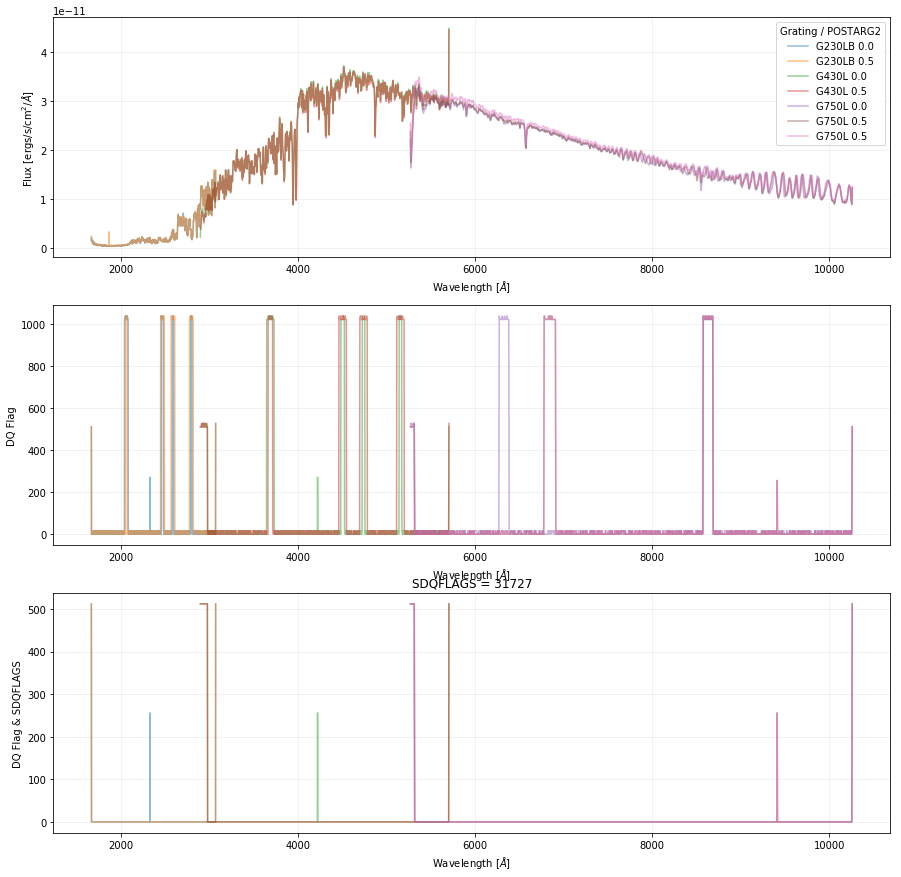

In [20]:
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(15, 15)

# Modify the standard "Serious Data Quality Flags" value to exclude DQ=16, 
# "pixel having dark rate > 5 σ times the median dark level":
sdqflags = fits.getval(fn, ext=1, keyword='SDQFLAGS') & ~16

for fn in outnames:
    outname = outnames[fn]
    with fits.open(outname) as f:
        axes[0].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['FLUX'], alpha=0.5, 
                label='{} {}'.format(f[0].header['OPT_ELEM'], f[0].header['POSTARG2']))
        axes[1].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['DQ'], alpha=0.5, 
                label='{} {}'.format(f[0].header['OPT_ELEM'], f[0].header['POSTARG2']))
        axes[2].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['DQ'] & sdqflags, alpha=0.5, 
                label='{} {}'.format(f[0].header['OPT_ELEM'], f[0].header['POSTARG2']))

axes[0].set_xlabel('Wavelength [$\AA$]')
axes[0].set_ylabel('Flux [ergs/s/cm$^{2}/\AA$]')
axes[0].legend(title='Grating / POSTARG2')

axes[1].set_xlabel('Wavelength [$\AA$]')
axes[1].set_ylabel('DQ Flag')

axes[2].set_xlabel('Wavelength [$\AA$]')
axes[2].set_ylabel('DQ Flag & SDQFLAGS')
axes[2].set_title('SDQFLAGS = {}'.format(sdqflags))

[ax.grid(True, alpha=0.2) for ax in axes]
None

Even though they fell at different Y-positions, the multiple 1D-extracted spectra at each grating are nearly identical.

------------------------------------------------------------------------------------------

## Running `splice`

Now, let's apply the IRAF `splice` routine to combine all these spectra together:

In [25]:
outnames

OrderedDict()

In [24]:
#fig, axes = plt.subplots(3, 1, sharex=True)
#fig.set_size_inches(15, 15)

# Plot component files:
'''
for fn in outnames:
    outname = outnames[fn]
    with fits.open(outname) as f:
        axes[0].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['FLUX'], alpha=0.2, 
                label='{}, {}"'.format(f[0].header['OPT_ELEM'], f[0].header['POSTARG2']))
        axes[1].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['ERROR'], alpha=0.2)
        axes[2].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['DQ'] & sdqflags, alpha=0.2)
'''

# Prepare input/output names:
innames = ','.join(outnames.values())
outname = '/Users/ogaz/specutils/test_data/g140l_spliced.fits'

   
'''
# Perform the splicing:
splice(innames, outname, sdqflags=sdqflags, spacing='coarse', verbose='no')  # SDQFLAGS already defined above

# Plot results:
with fits.open(outname) as f:
    axes[0].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['FLUX'], 'k', 
                 label='Spliced', alpha=0.5)
    axes[1].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['ERROR'], 'k', alpha=0.7)
    axes[2].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['DQ'] & sdqflags, 'k', alpha=0.7)

axes[0].set_title('HD 115383')
axes[0].legend(title='Grating / POSTARG2', loc='best')
[ax.set_xlabel('Wavelength [$\AA$]') for ax in axes]
axes[0].set_ylabel('Flux [ergs/s/cm$^{2}/\AA$]')
axes[1].set_ylabel('Flux Error [ergs/s/cm$^{2}/\AA$]')
axes[2].set_ylabel('DQ Flags')
None
'''

"\n# Perform the splicing:\nsplice(innames, outname, sdqflags=sdqflags, spacing='coarse', verbose='no')  # SDQFLAGS already defined above\n\n# Plot results:\nwith fits.open(outname) as f:\n    axes[0].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['FLUX'], 'k', \n                 label='Spliced', alpha=0.5)\n    axes[1].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['ERROR'], 'k', alpha=0.7)\n    axes[2].plot(f[1].data[0]['WAVELENGTH'], f[1].data[0]['DQ'] & sdqflags, 'k', alpha=0.7)\n\naxes[0].set_title('HD 115383')\naxes[0].legend(title='Grating / POSTARG2', loc='best')\n[ax.set_xlabel('Wavelength [$\\AA$]') for ax in axes]\naxes[0].set_ylabel('Flux [ergs/s/cm$^{2}/\\AA$]')\naxes[1].set_ylabel('Flux Error [ergs/s/cm$^{2}/\\AA$]')\naxes[2].set_ylabel('DQ Flags')\nNone\n"

<br>
<br>
# Fake some STIS data into regular intervals

In [19]:
taba = table.Table.read('test_data/ocr7ncmhq_x1d.fits')
tabb = table.Table.read('test_data/ocr7ncmiq_x1d.fits')

In [20]:
new_wave = np.linspace(min(taba['WAVELENGTH'][0]), max(taba['WAVELENGTH'][0]), num=1024)
taba['WAVELENGTH'] = new_wave
tabb['WAVELENGTH'] = new_wave

In [22]:
for filename in ['test_data/ocr7ncmhq_x1d.fits', 'test_data/ocr7ncmiq_x1d.fits']:
    with fits.open(filename) as fits_file:
        tab = table.Table.read(filename, hdu=1)
        
        tab['WAVELENGTH'] = new_wave
        
        saved_head = fits_file[1].header
        new_table = fits.table_to_hdu(tab)
        fits_file[1] = new_table
        fits_file[1].header = saved_head
        fits_file.writeto(filename.replace("_x1d.fits","_uniform.fits"), 
                          overwrite=True)

In [79]:
print(spectra_python_even.spectral_axis[0:200])

[5269.42588739 5274.30580459 5279.1857218  5284.06563901 5288.94555621
 5293.82547342 5298.70539062 5303.58530783 5308.46522503 5313.34514224
 5318.22505944 5323.10497665 5327.98489385 5332.86481106 5337.74472826
 5342.62464547 5347.50456267 5352.38447988 5357.26439708 5362.14431429
 5367.02423149 5371.9041487  5376.7840659  5381.66398311 5386.54390032
 5391.42381752 5396.30373473 5401.18365193 5406.06356914 5410.94348634
 5415.82340355 5420.70332075 5425.58323796 5430.46315516 5435.34307237
 5440.22298957 5445.10290678 5449.98282398 5454.86274119 5459.74265839
 5464.6225756  5469.5024928  5474.38241001 5479.26232722 5484.14224442
 5489.02216163 5493.90207883 5498.78199604 5503.66191324 5508.54183045
 5513.42174765 5518.30166486 5523.18158206 5528.06149927 5532.94141647
 5537.82133368 5542.70125088 5547.58116809 5552.46108529 5557.3410025
 5562.2209197  5567.10083691 5571.98075412 5576.86067132 5581.74058853
 5586.62050573 5591.50042294 5596.38034014 5601.26025735 5606.14017455
 5611.0

In [82]:
with open('wave.tab','w') as f:
    for num in spectra_python_even.spectral_axis:
        f.write("{}\n".format(num.value))

<br>
<br>
# Add some weights to the faked even STIS data

In [14]:
tabaa = table.Table.read('test_data/ocr7ncmhq_uniform.fits')
tabbb = table.Table.read('test_data/ocr7ncmiq_uniform.fits')

In [15]:
tabaa

SPORDER,NELEM,WAVELENGTH [1024],GROSS [1024],BACKGROUND [1024],NET [1024],FLUX [1024],ERROR [1024],NET_ERROR [1024],DQ [1024],A2CENTER,EXTRSIZE,MAXSRCH,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST,EXTRLOCY [1024],OFFSET
,,Angstroms,Counts/s,Counts/s,Counts/s,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),Counts/s,,pix,pix,pix,pix,pix,pix,pix,pix,pix
int16,int16,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32
1,1024,5269.4258873892895 .. 10261.581188369679,6092.4155 .. 831.36334,7.0387063 .. 21.164642,6085.377 .. 810.1987,2.3778528e-11 .. 1.232207e-11,1.1882678e-12 .. 5.897913e-13,306.98206 .. 39.09321,512 .. 512,59.14557,7.0,1024,5.0,5.0,-40.0,55.0,59.518883 .. 58.778164,512.8503


In [40]:
for filename in ['test_data/ocr7ncmhq_uniform.fits', 'test_data/ocr7ncmiq_uniform.fits']:
    with fits.open(filename) as fits_file:
        tab = table.Table.read(filename, hdu=1)
        
        new = table.Column([np.random.rand(1024)], name='WEIGHT')
        tab.add_column(new, index=10)
        
        saved_head = fits_file[1].header
        new_table = fits.table_to_hdu(tab)
        fits_file[1] = new_table
        fits_file.writeto(filename.replace('uniform','weights'), overwrite=True)

In [41]:
tabw = table.Table.read('test_data/ocr7ncmhq_weights.fits')
tabww = table.Table.read('test_data/ocr7ncmiq_weights.fits')

In [42]:
weight_arr = [np.random.rand(1024)]
tabaa['WEIGHT'] = weight_arr
tabbb['WEIGHT'] = weight_arr

In [43]:
tabw

SPORDER,NELEM,WAVELENGTH [1024],GROSS [1024],BACKGROUND [1024],NET [1024],FLUX [1024],ERROR [1024],NET_ERROR [1024],DQ [1024],WEIGHT [1024],A2CENTER,EXTRSIZE,MAXSRCH,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST,EXTRLOCY [1024],OFFSET
,,Angstroms,Counts/s,Counts/s,Counts/s,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),Counts/s,,,pix,pix,pix,pix,pix,pix,pix,pix,pix
int16,int16,float64,float32,float32,float32,float32,float32,float32,int16,float64,float32,float32,int16,float32,float32,float32,float32,float32,float32
1,1024,5269.4258873892895 .. 10261.581188369679,6092.4155 .. 831.36334,7.0387063 .. 21.164642,6085.377 .. 810.1987,2.3778528e-11 .. 1.232207e-11,1.1882678e-12 .. 5.897913e-13,306.98206 .. 39.09321,512 .. 512,0.5692761830307689 .. 0.32348495119529963,59.14557,7.0,1024,5.0,5.0,-40.0,55.0,59.518883 .. 58.778164,512.8503


In [44]:
tabww

SPORDER,NELEM,WAVELENGTH [1024],GROSS [1024],BACKGROUND [1024],NET [1024],FLUX [1024],ERROR [1024],NET_ERROR [1024],DQ [1024],WEIGHT [1024],A2CENTER,EXTRSIZE,MAXSRCH,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST,EXTRLOCY [1024],OFFSET
,,Angstroms,Counts/s,Counts/s,Counts/s,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),Counts/s,,,pix,pix,pix,pix,pix,pix,pix,pix,pix
int16,int16,float64,float32,float32,float32,float32,float32,float32,int16,float64,float32,float32,int16,float32,float32,float32,float32,float32,float32
1,1024,5269.4258873892895 .. 10261.581188369679,6576.43 .. 1003.088,10.163393 .. 25.830063,6566.2666 .. 977.25793,2.5510307e-11 .. 1.2561328e-11,1.2655888e-12 .. 5.7313355e-13,328.6095 .. 44.89269,512 .. 512,0.19157772254588668 .. 0.34629254598140036,59.16761,7.0,1024,5.0,5.0,-40.0,55.0,59.54099 .. 58.800262,512.8723


In [46]:
head = fits.getheader('test_data/ocr7ncmhq_weights.fits', ext=1)

In [47]:
head

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                47138 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'SPORDER '                                                            
TFORM1  = 'I       '                                                            
TNULL1  =               -32767                                                  
TTYPE2  = 'NELEM   '                                                            
TFORM2  = 'I       '        